In [1]:
""" Experiment 2: Primitive vs Balanced curriculum performance with few training examples.
Compare performance in rich and lazy regime
"""

In [ ]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D

from cryptic_rnn import *

# Functions

In [5]:
def plotNNs(loss_arrays, title='', labels=['train', 'test1', 'test2'],  colors=['green', 'yellow', 'red']):
""" Plots training loss curves"""
    fig, axs = plt.subplots()
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1)
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs.plot(x, mn, label = labels[i], color = colors[i])
        axs.fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs.set_xlabel('epoch')
    axs.set_ylabel('loss')
    axs.legend()
    
    fig.suptitle(title, fontsize=10)

######### running functions

def run_exp(trainseqs_old_b, trainseqs_old_p, testseqs_old, cue_dict):
    """ Trains an RNN with primitive and control training set - with paired initialization
    Args:
       trainseqs_old_b: balanced training seqs
       trainseqs_old_p: primitive training seqs
       testseqs_old: test seqs
       cue_dict: dictionary of symbols and their integer values
    Returns
       dictionary with cue_dict, test sequences, models, losses and accuracies for the RNNs.
    """
    ### randomly assign values to symbols
    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    ### recalculate  outputs with new cue_dict, and load data 
    # balanced
    trainseqs = change_dict(trainseqs_old_b, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_b = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    # primitive
    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    # test
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # paired RNN initialization
    model_b = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_p = copy.deepcopy(model_b)
    criterion = nn.MSELoss()
    # run balanced
    optimizer = torch.optim.Adam(model_b.parameters(), lr=learningRate)
    loss1, test_loss1 = run_loss(model_b,optimizer,criterion, trainset_b, [trainset_b, testset], epochs, hidden_size)
    # run primitive
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, test_loss2 = run_loss(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs, hidden_size)
    
    return {'cue_dict':cue_dict,'test': testset,\
           'loss_b':loss1, 'test_loss_b':test_loss1, 'mod_b': model_b,\
           'loss_p':loss2, 'test_loss_p':test_loss2, 'mod_p': model_p}

def run_plot(trainseqs_b, trainseqs_p, testseqs, cue_dict):
    """ Runs simulations in parallel, collecting results for each group of RNNs
    Args:
       trainseqs_b: balanced training seqs
       trainseqs_p: primitive training seqs
       testseqs: test seqs
       cue_dict: dictionary of symbols and their integer values
    Returns
       dictionary with cue_dict, test sequences, models, losses and accuracies for the RNNs.
    """
    # run simulations in parallel and print run time
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs_b, trainseqs_p,testseqs, cue_dict) for i in tqdm(range(num_sims)))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)
    
    ### collect values from list of results
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    # balanced results
    losses_b = np.hstack([r['loss_b'] for r in res])
    train_losses_b = np.array([r['test_loss_b'][:,0] for r in res]).T
    test_losses_b = np.array([r['test_loss_b'][:,1] for r in res]).T
    mods_b = [r['mod_b'] for r in res]
    # primitive results
    losses_p = np.hstack([r['loss_p'] for r in res])
    train_losses_p = np.array([r['test_loss_p'][:,0] for r in res]).T
    test_losses_p = np.array([r['test_loss_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
        
    # plot loss curves
    plotNNs([losses_b, train_losses_b, test_losses_b],labels=['train', 'test-train', 'test'], colors = ['green', 'orange', 'red'], title = 'balanced -no primitives')
    plotNNs([losses_p, train_losses_p, test_losses_p],labels=['train', 'test-train',  'test'], colors = ['green', 'orange', 'red'], title = 'with primitives')
    
    # plot prediction-ground truth correlations
    plt.figure()
    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =True)
    plt.title('balanced-without primitives; r^2 = '+ str(round(r2_b, 3)))
    plt.figure()
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = True)
    plt.title('with primitives; r^2 = '+ str(round(r2_p, 3)))
    print(losses_b[-1,:].shape)
    print(np.array(test_losses_b).shape)
    
    # data frame of train and test MSE
    acc_df = pd.DataFrame({'train_b': train_losses_b[-1,:],'train_p': train_losses_p[-1,:].reshape(-1),\
                           'test_b': test_losses_b[-1,:],'test_p': test_losses_p[-1,:]})
    # print mean training loss at end of training
    print('balanced loss', losses_b[-1,:].mean())
    print('primitives loss', losses_p[-1,:].mean())
    
    return {'mods_b':mods_b, 'mods_p':mods_p, 'losses_b_final': losses_b[-1,:], 'losses_p_final':losses_p[-1,:],\
            'res':res, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }

def extract_ft(res1):
    """ extract results of the fully trained RNNs (where fully trained is a final MSE < 1)
    Args:
        res1: result dictionary in the form of the run_plot function output
    Returns:
        a dictionary of results including only the fully trained RNNs
    """
    acc_df = res1['acc_df']
    ft_idx = acc_df[(acc_df['train_b'] < 1) & (acc_df['train_p'] < 1)].index
    
    tests = [res1['tests'][i] for i in ft_idx]
    cue_dicts = [res1['cue_dicts'][i] for i in ft_idx]   
    mods_b = [res1['mods_b'][i] for i in ft_idx]
    mods_p = [res1['mods_p'][i] for i in ft_idx]
    
    return {'mods_b':mods_b, 'mods_p':mods_p,'tests': tests, 'cue_dicts': cue_dicts}



## RNN params

In [9]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## Sequences

In [10]:
# generate training and test sequence sets
# simple addition sequences with 2 input symbols

ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms, cue_dict)[:2]
trainseqs_b = trainseqs + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives

print('trainseqs ',trainseqs)
print('trainseqs_b ',trainseqs_b)
print('trainseqs_p ',trainseqs_p)

testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]

print('testseqs ', testseqs )

cue_dict  {'A': 7, 'B': 9, 'C': 11, 'D': 2}
primitives  [[('+', 'A'), '=', 7], [('+', 'B'), '=', 9], [('+', 'C'), '=', 11], [('+', 'D'), '=', 2]]
trainseqs  [[('+', 'A'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'C'), '=', 20]]
trainseqs_b  [[('+', 'A'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'C'), '=', 20], [('+', 'A'), ('+', 'C'), '=', 18], [('+', 'B'), ('+', 'D'), '=', 11]]
trainseqs_p  [[('+', 'A'), ('+', 'B'), '=', 16], [('+', 'B'), ('+', 'C'), '=', 20], [('+', 'A'), '=', 7], [('+', 'B'), '=', 9], [('+', 'C'), '=', 11], [('+', 'D'), '=', 2]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 14], [('+', 'A'), ('+', 'D'), '=', 9], [('+', 'B'), ('+', 'A'), '=', 16], [('+', 'B'), ('+', 'B'), '=', 18], [('+', 'C'), ('+', 'A'), '=', 18], [('+', 'C'), ('+', 'B'), '=', 20], [('+', 'C'), ('+', 'C'), '=', 22], [('+', 'C'), ('+', 'D'), '=', 13], [('+', 'D'), ('+', 'A'), '=', 9], [('+', 'D'), ('+', 'B'), '=', 11], [('+', 'D'), ('+', 'C'), '=', 13], [('+', 'D'), ('+', 'D'), '=', 4]]


100%|███████████████████████████████████████| 800/800 [2:20:08<00:00, 10.51s/it]


run time:  141.39111987749735
(800,)
(1500, 800)
balanced loss 0.08130087791114761
primitives loss 1.350930885880686


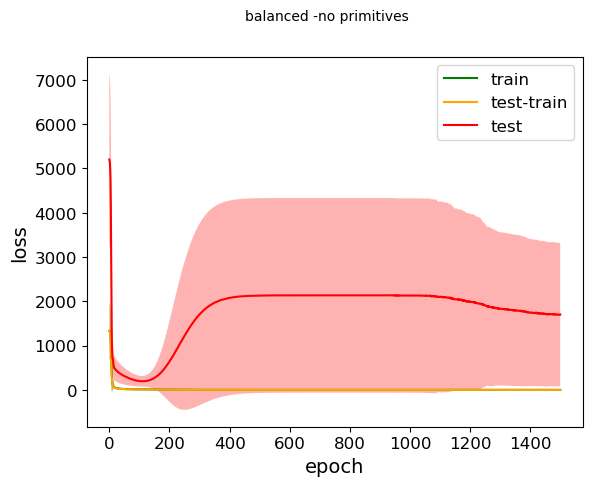

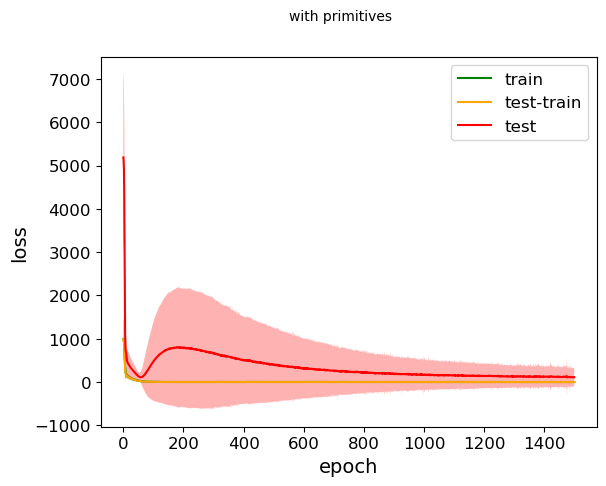

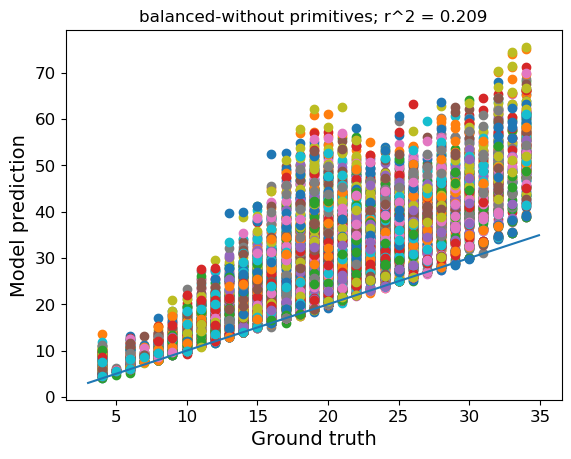

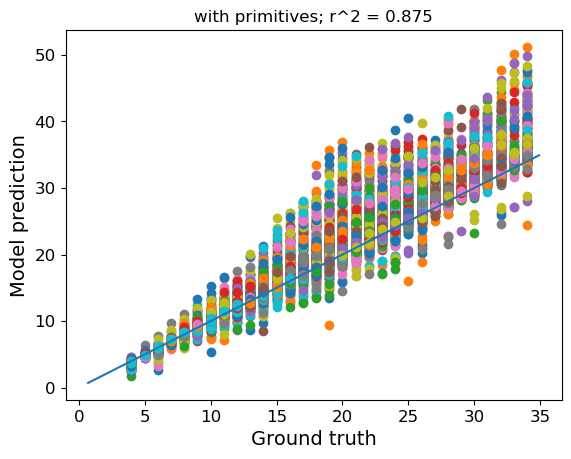

In [33]:
epochs = 1500
num_sims = 800

res_2input_20 = run_plot(trainseqs_b, trainseqs_p, testseqs, cue_dict)

In [34]:
# select fully trained ones
accres2_20 = extract_ft(res_2input_20)

In [37]:
# save
savedir = 'Results/res_20'
with open(savedir, 'wb') as f:
    pickle.dump(accres2_20, f)


# Lazy regime

Weights initialized with large variance ( xavier_gain = 5, in rich regime xavier_gain = 0.0001)

100%|█████████████████████████████████████████| 200/200 [18:32<00:00,  5.56s/it]


run time:  20.05456486145655
(200,)
(1500, 200)
balanced loss 6.180679038359842
primitives loss 11.978812045042664


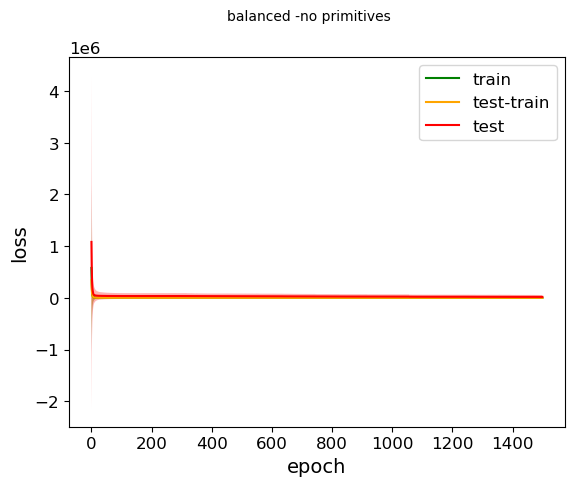

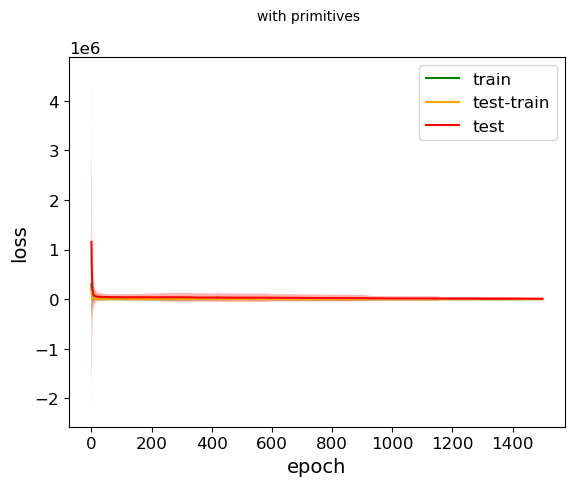

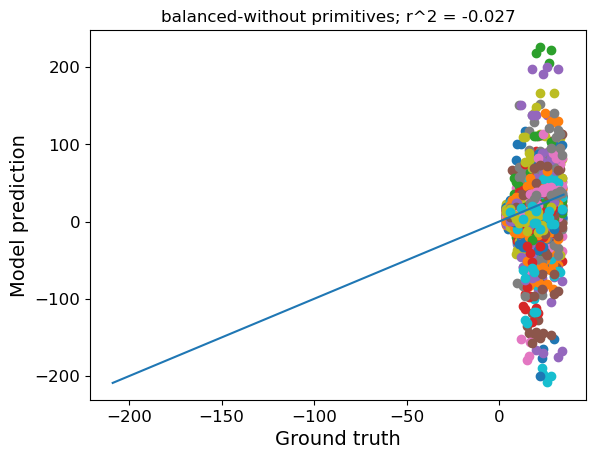

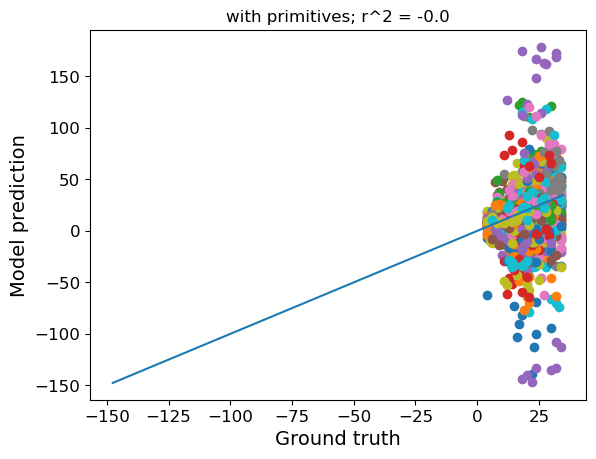

In [38]:
hidden_size=20
epochs = 1500
num_sims = 200
xavier_gain = 5

res_2input_lazy = run_plot(trainseqs_b, trainseqs_p, testseqs, cue_dict)

In [39]:
# extract fully trained RNNs
ft_res_2input_lazy = extract_ft(res_2input_lazy)

In [42]:
savedir = 'Results/res_20_lazy'
with open(savedir, 'wb') as f:
    pickle.dump(ft_res_2input_lazy, f)
